In [1]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from functions import *

In [2]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col = 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col = 'tstp')

In [3]:
train = extract_dmhq(train)
test = extract_dmhq(test)

### Creat lag series for weather

In [4]:
train_date = train.iloc[:,9:]
train_w = lag_ahead_series(train.temperature, 196, 1, 1)
train_date , train_w = train_date.align(train_w, 'inner', axis = 0)
ftrain = pd.concat([train_date, train_w], axis = 1)
ttrain = train.energy
ftrain, ttrain = ftrain.align(ttrain, 'inner', axis = 0)

In [5]:
test_date = test.iloc[:,9:]
test_w = lag_ahead_series(test.temperature, 196, 1, 1)
test_date , test_w = test_date.align(test_w, 'inner', axis = 0)
ftest = pd.concat([test_date, test_w], axis = 1)
ttest = test.energy
ftest, ttest = ftest.align(ttest, 'inner', axis = 0)

In [6]:
feature_list = list(ftrain.columns)

### Seeking outliers

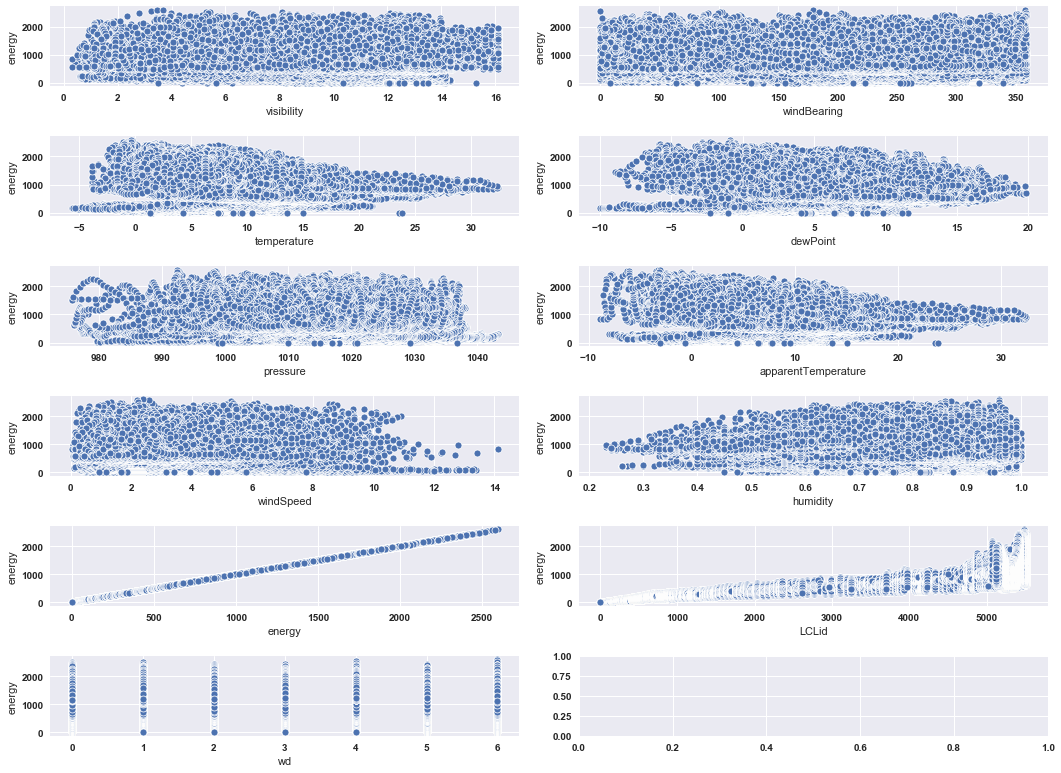

In [145]:
scatter_plot(train)

### Distribution

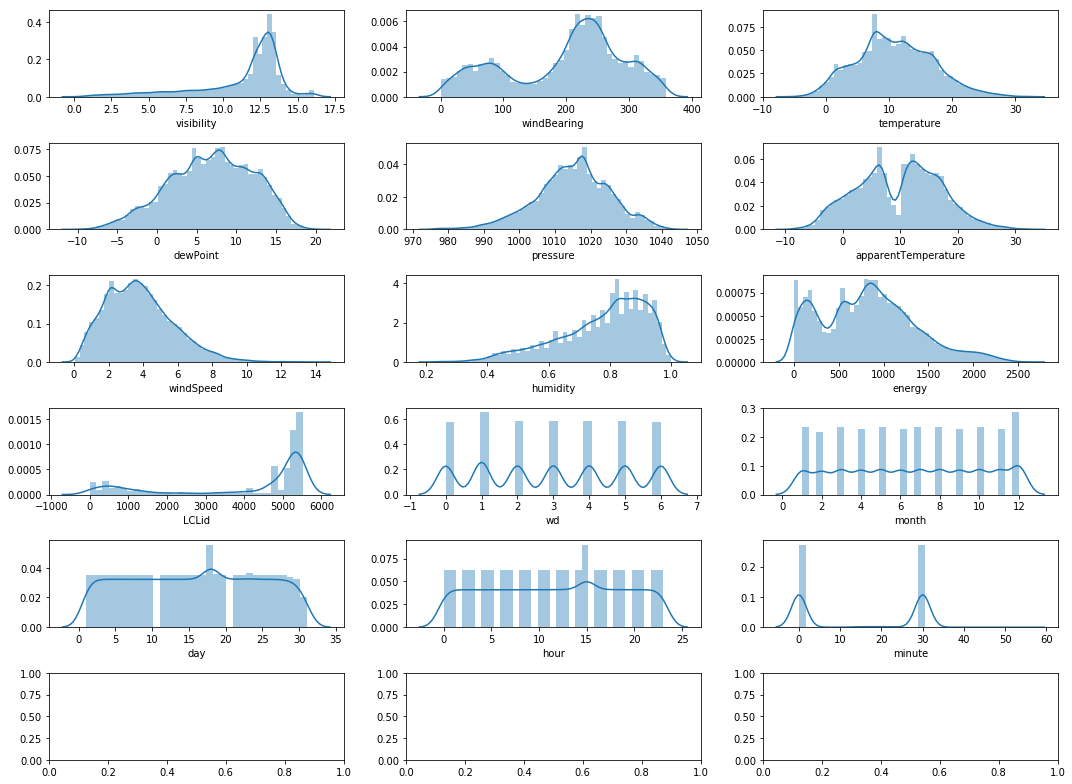

In [7]:
distri_plot(train)

### Feature Selection: Tree-Based

In [7]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel


reg = ExtraTreesRegressor(n_estimators = 50)
reg.fit(ftrain, ttrain)
model = SelectFromModel(reg, prefit=True)
#cols = model.get_support(indices=True)
#mt_feature = model.transform(ftrain)

In [8]:
# Get numerical feature importances
importances = list(reg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: LCLid                Importance: 0.563
Variable: hour                 Importance: 0.219
Variable: temperature1(t-28)   Importance: 0.016
Variable: temperature1(t-30)   Importance: 0.012
Variable: temperature1(t-29)   Importance: 0.012
Variable: month                Importance: 0.011
Variable: temperature1(t-26)   Importance: 0.008
Variable: wd                   Importance: 0.006
Variable: temperature1(t-25)   Importance: 0.006
Variable: temperature1(t-78)   Importance: 0.004
Variable: temperature1(t-76)   Importance: 0.004
Variable: temperature1(t-33)   Importance: 0.004
Variable: temperature1(t-31)   Importance: 0.004
Variable: temperature1(t-173)  Importance: 0.003
Variable: temperature1(t-172)  Importance: 0.003
Variable: temperature1(t-126)  Importance: 0.003
Variable: temperature1(t-75)   Importance: 0.003
Variable: temperature1(t-48)   Importance: 0.003
Variable: temperature1(t-44)   Importance: 0.003
Variable: temperature1(t-41)   Importance: 0.003
Variable: temperatur

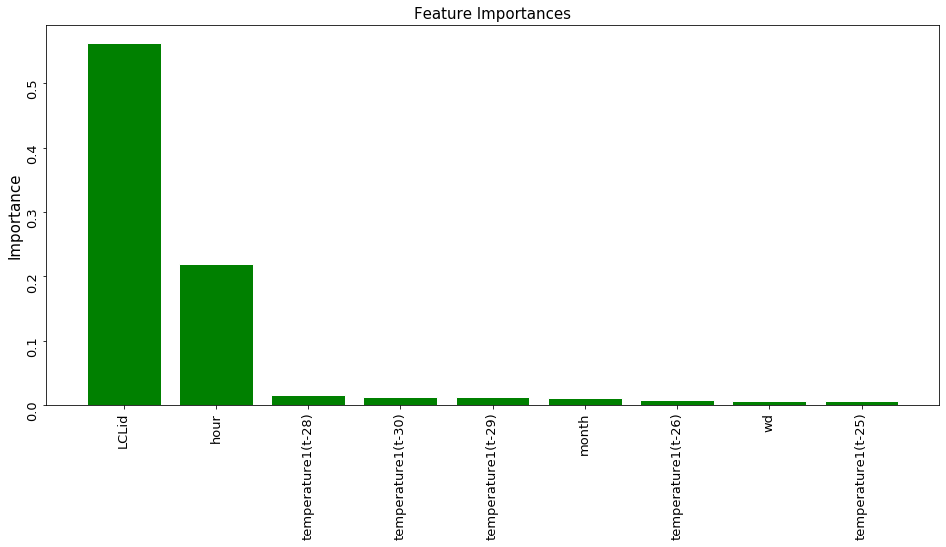

In [9]:
# important features
score = [i[1] for i in feature_importances if i[1] >= 0.005]
picked_features = [i[0] for i in feature_importances if i[1] >= 0.005]
# list of x locations for plotting
x_values = list(range(len(score)))
# Make a bar chart
fig = plt.figure(figsize=(16,7))
font = {'size'   : 15}
plt.rc('font', **font)
plt.bar(x_values, score, orientation = 'vertical', color = 'g', edgecolor = 'w', linewidth = 1)
# Tick labels for x axis
plt.xticks(x_values, picked_features, rotation=90, fontsize = 13)
plt.yticks(rotation='vertical', fontsize = 13)
# Axis labels and title
plt.ylabel('Importance',**font); 
plt.title('Feature Importances',**font);


In [10]:
pftrain = ftrain[picked_features]
pftest = ftest[picked_features]
#pftrain = ftrain
#pftest = ftest

### Scaling 

In [69]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler() ## will be used later in test set
mmscaler.fit(pftrain)
pftrain = mmscaler.transform(pftrain)
pftest = mmscaler.transform(pftest)

### Standardization

In [70]:
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
qt.fit(pftrain)
pftrain = qt.transform(pftrain)
pftest = qt.transform(pftest)

### SVM Regression

In [17]:
from sklearn.svm import SVR

svr = SVR(kernel='poly', degree=5,
          gamma='scale', coef0=0.25,
          tol=0.001, C=2.1,
          epsilon=0.1, shrinking=True,
          cache_size=200,
          verbose=True, max_iter=-1)
X = ftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.5)

%time svr.fit(train_X, train_y)

[LibSVM]CPU times: user 57.9 s, sys: 328 ms, total: 58.2 s
Wall time: 58.4 s


SVR(C=2.1, cache_size=200, coef0=0.25, degree=5, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=True)

In [18]:
ypred = svr.predict(val_X)
o_y = np.transpose(val_y.to_numpy())
p_y = np.transpose(ypred)
get_eval(o_y, p_y)

MSE: 96079.87544450589
MAE: 228.81132976332458
r2_score: 0.6467327507803928


In [19]:
ypred_t = svr.predict(ftest)
o_y = np.transpose(ttest.to_numpy())
p_y = np.transpose(ypred_t)
get_eval(o_y, p_y)

MSE: 197767.14689653358
MAE: 362.7684424642719
r2_score: -0.2450847444544286


### Extra Trees Regression

In [189]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(min_samples_split=10, max_depth = 15, min_samples_leaf=15)
X = ftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.5)

%time etr.fit(train_X, train_y)

CPU times: user 22.5 s, sys: 53.7 ms, total: 22.5 s
Wall time: 22.5 s


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=15, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=15,
                    min_samples_split=10, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

### Validation set

In [190]:
ypred = etr.predict(val_X)
o_y = np.transpose(val_y.to_numpy())
p_y = np.transpose(ypred)
get_eval(o_y, p_y)

MSE: 3943.76888069854
MAE: 41.58006425225037
r2_score: 0.9856114833203514


### Testing set

In [192]:
## feature scaling
# single_test = pd.concat([single_wt, ahead_et], axis = 1) ## without weather recency effect
## with weather recency effect
ypred_t = etr.predict(ftest)
o_y = np.transpose(ttest.to_numpy())
p_y = np.transpose(ypred_t)
get_eval(o_y, p_y)

MSE: 12663.511078100453
MAE: 84.87903115505208
r2_score: 0.9202741977016968


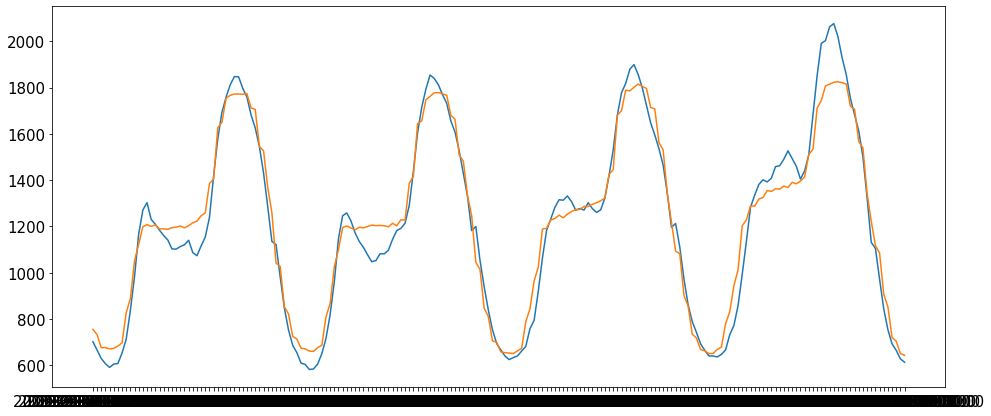

In [193]:
fig = plt.figure(figsize = (16,7))
plt.plot(ttest.iloc[0:196])
plt.plot(ypred_t[0:196])

In [194]:
r2_list = []
for i in range(ttest.shape[0] -96):
    o_y = np.transpose(ttest.iloc[i:96+i].to_numpy())
    p_y = np.transpose(ypred_t[i:96+i])
    r2 = r2_score(o_y, p_y)
    r2_list.append(r2)

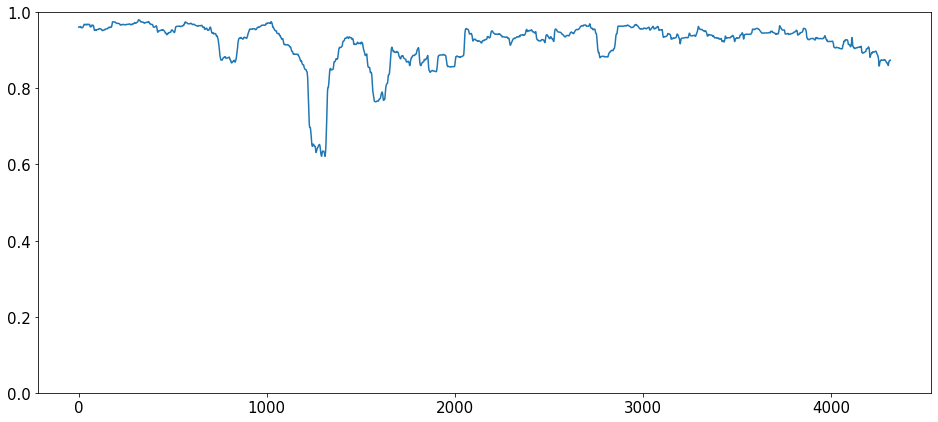

In [195]:
fig = plt.figure(figsize=(16,7))
plt.ylim(0)
plt.plot(r2_list)

### HistGradientBoostingRegression

In [196]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(loss='least_squares', 
                                    learning_rate=0.1, 
                                    max_iter=100, 
                                    max_leaf_nodes=3, 
                                    max_depth=None, 
                                    min_samples_leaf=20, 
                                    l2_regularization=0.0, 
                                    max_bins=80, 
                                    warm_start=False, 
                                    scoring=None, 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=1e-07, 
                                    verbose=0, 
                                    random_state=None)


In [197]:
from sklearn.model_selection import train_test_split
X = ftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time hgb.fit(train_X, train_y)

CPU times: user 1.58 s, sys: 63.1 ms, total: 1.64 s
Wall time: 1.64 s


HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=80, max_depth=None,
                              max_iter=100, max_leaf_nodes=3,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

### Validation set

In [198]:
ypred = hgb.predict(val_X)

In [199]:
o_y = np.transpose(val_y.to_numpy())
p_y = np.transpose(ypred)
get_eval(o_y, p_y)

MSE: 12552.2789954545
MAE: 80.88741391384059
r2_score: 0.9532801894114226


### Testing set

In [200]:
ypred_t = hgb.predict(ftest)

In [201]:
o_yt = np.transpose(ttest.to_numpy())
p_yt = np.transpose(ypred_t)
get_eval(o_yt, p_yt)

MSE: 49569.82469985352
MAE: 173.33986523804708
r2_score: 0.6879227238315904


### Random Forest Regression

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
rfr = RandomForestRegressor(n_estimators=100)

X = ftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

%time rfr.fit(train_X, train_y)


CPU times: user 5min 4s, sys: 626 ms, total: 5min 4s
Wall time: 5min 5s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [155]:
ypred = rfr.predict(val_X)
get_eval(val_y, ypred)

MSE: 2658.199602110279
MAE: 33.877947421995515
r2_score: 0.9902895294917138


In [156]:
ypred_t = rfr.predict(ftest)
get_eval(ttest, ypred_t)

MSE: 21380.98388618843
MAE: 105.92219092820599
r2_score: 0.8652536302190006




### Xgboost: Manual

In [203]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = ftrain
y = ttrain
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

xgbr = xgb.XGBRegressor(njobs= 4)

xgbr.fit(train_X, train_y)
#rc = MultiOutputRegressor(xgbr, cv = 5, random_state = 123)
#rc.fit(train_X, train_y)

[18:03:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, njobs=4, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### Result evaluation: validation set

In [204]:
yhat = xgbr.predict(val_X)

In [205]:
get_eval(val_y, yhat)

MSE: 6659.532800390198
MAE: 56.26063662766898
r2_score: 0.9756845891184398


### Result evaluation: test set

In [207]:
ypred = xgbr.predict(ftest)

In [208]:
get_eval(ttest, ypred)

MSE: 31619.841297192703
MAE: 141.55804410039215
r2_score: 0.8009306265524387


### LSTM

In [ ]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(ftrain, ttrain, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.to_numpy().reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.to_numpy().reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.to_numpy().reshape((train_y.shape[0],1, 1))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             50800     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 1)              51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 154469.6179
Epoch 2/50
 - 2s - loss: 65738.5128
Epoch 3/50
 - 2s - loss: 57016.5533
Epoch 4/50
 - 2s - loss: 54099.3749
Epoch 5/50
 - 2s - loss: 47830.4414
Epoch 6/50
 - 2s - loss: 39731.8311
Epoch 7/50
 - 2s - loss: 34798.6977
Epoch 8/50
 - 2s - loss: 31744.4746
Epoch 9/50
 - 2s - loss: 29732.3765
Epoch 10/50
 - 2s - loss: 28211.9781
Epoch 11/50
 - 2s - loss: 26522.5056
Epoch 12/50
 - 2s - loss: 25595.6869
Epoch 13/50
 - 2s - loss: 24543.8752
Epoch 14/50
 - 2s - loss: 23735.1109
Ep

### Validation sets

**Metrics**


In [170]:
yhat = model.predict(val_X.to_numpy().reshape(val_X.shape[0], 1, val_X.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

In [171]:
get_eval(val_y, yhat)

MSE: 28612.46673241929
MAE: 122.23238053122022
r2_score: 0.8938445803970976


In [172]:
real = val_y.to_numpy()
guess = yhat
real = real[1:2,:96]
guess = guess[1:2,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

IndexError: too many indices for array

### Testing sets

In [173]:
test_x = pftest
yhat = model.predict(test_x.to_numpy().reshape(test_x.shape[0], 1, test_x.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

**Metrics**

In [175]:
test_y = ttest
get_eval(test_y, yhat)

MSE: 53545.26224225057
MAE: 191.5230855016007
r2_score: 0.6625492192257998


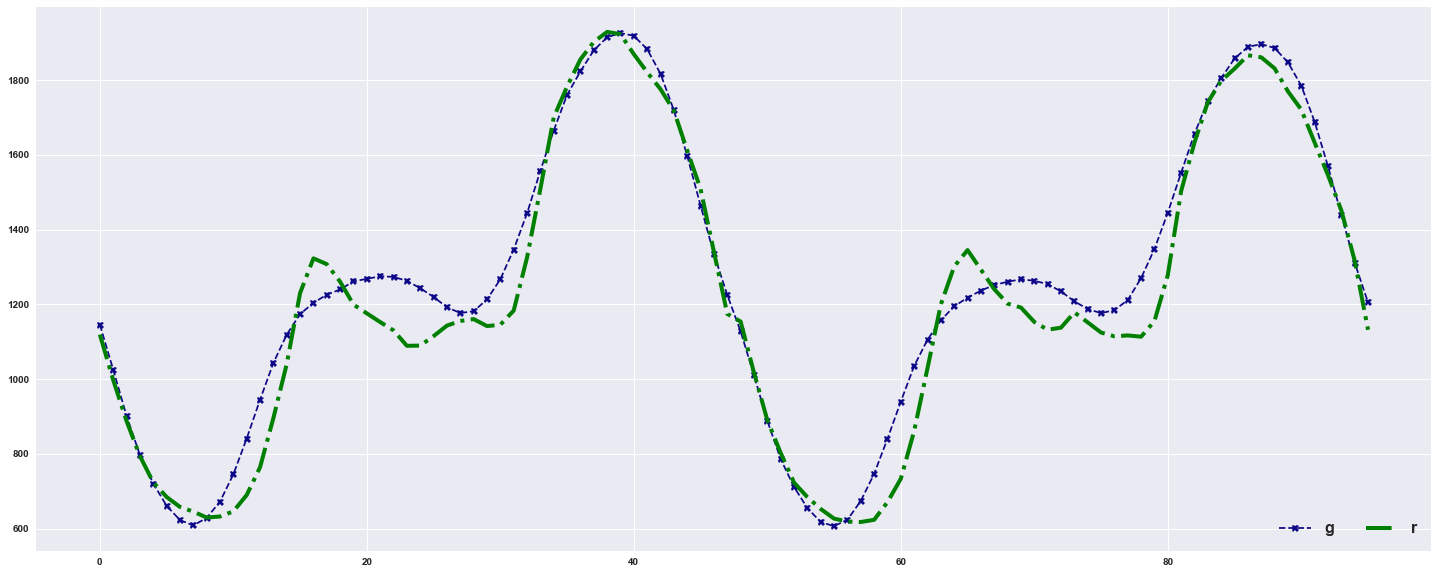

In [427]:
real = test_y.to_numpy()
guess = yhat
real = real[0:1,:96]
guess = guess[0:1,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()